# Spatial Interpolation of WQ data

This document includes Python codes that conduct spatial interpolation for water quality data.

If you are running the code in ArcGIS Notebook, you'll need to install the following packages:

`conda install -c anaconda pandas scikit-learn
conda install -c conda-forge geopandas rasterio pykrige rioxarray
pip install pyidw
conda install -c esri arcgis
`

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
import earthpy as et
import earthpy.plot as ep
import time
#import rioxarray as rxr


from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from pyidw import idw
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
arcpy.env.overwriteOutput = True

# 1. Load Discrete Data and Continuous Data

In [2]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

In [3]:
dfDis_orig = pd.read_csv(path + r"OEAT_Discrete-2022-Oct-07.csv")
dfCon_orig = pd.read_csv(path + r"OEAT_Continuous-2022-Nov-16.csv")

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3397: DtypeWarning: Columns (2,3,4,5,6,7,11,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3397: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 2 Preprocess Data
Preset function parameters

In [4]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]

dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze AP','Pine Island Sound Aquatic Preserve':'Pine Island'}
dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon_orig["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]


Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'
Para = 'Dissolved Oxygen'
SpatialRef = '3086'
dry_start,dry_end = '11/01/2016','04/30/2017'
wet_start,wet_end = '05/01/2017','10/31/2017'

Function to preprocess dataframes

In [5]:
def preprocess(df,col_ls,para_ls):
    
    # ------- Select columns and parameters ------
    df = df[col_ls]
    df = df.loc[df["ParameterName"].isin(para_ls)]
    df["timestamp"]=  pd.to_datetime(df['SampleDate'])
    #---------- remove outliers -----------------
    # Remove total nitrogen outliers (>100)
    df.drop(df[(df['ParameterName'] == 'Total Nitrogen') & 
                     (df['ResultValue'] > 10)].index,inplace=True)

    # Remove a single measurement in 1996-07-22 (RowID: 1582917)
    df.drop(df[df['RowID'] == 1582917].index, inplace=True)

    # Remove turbidity outliers (>25)
    df.drop(df[(df['ParameterName'] == 'Turbidity') & 
                     (df['ResultValue'] > 25)].index, inplace=True)

    # Remove Secchi Depth before 1995 (117 records)
    df.drop(df[(df['ParameterName'] == 'Secchi Depth') & 
                     (df['Year'] < 1995)].index, inplace=True)
    
    return df

Preprocess dataframes

In [6]:
dfDis = preprocess(dfDis_orig, col_ls, para_ls)
dfCon = preprocess(dfCon_orig, col_ls, para_ls)

# 2. Combine Dis Data and Con Data in Dry Season

Combine dataframes

In [7]:
def combine_dis_con(df_dis,df_con, area, parameter, start, end):
    
    # Select discrete data in time frame and managed areas
    df_dis = df_dis[(df_dis["ParameterName"]==Para)&(df_dis["ManagedAreaName"]==Area)]
    df_dis = df_dis[(df_dis['timestamp'] > start)&(df_dis['timestamp'] < end)]
    df_dis_mean = df_dis.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

    # Select wet season data in time frame and managed areas
    df_con = df_con[(df_con["ParameterName"]==Para)&(df_con["ManagedAreaName"]==Area)]
    df_con = df_con[(df_con['timestamp'] > start)&(df_con['timestamp'] < end)]
    df_con_mean = df_con.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()
   
    # Concatenate dry and wet dataframes
    df_mean = pd.concat([df_dis_mean,df_con_mean],ignore_index=True)
    gdf = gpd.GeoDataFrame(df_mean, geometry = gpd.points_from_xy(df_mean.Longitude_DD, df_mean.Latitude_DD), crs="EPSG:4326")
    
    return df_mean, gdf

In [8]:
dfDryMean, gdfDry = combine_dis_con(dfDis,dfCon,Area,Para,dry_start,dry_end)
dfWetMean, gdfWet = combine_dis_con(dfDis,dfCon,Area,Para,wet_start,wet_end)

gdfDry.to_crs(int(SpatialRef)).to_file(gis_path+'gdfDry.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWet.to_crs(int(SpatialRef)).to_file(gis_path+'gdfWet.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_3780\906926102.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(gis_path+'gdfDry.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_3780\906926102.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWet.to_crs(int(SpatialRef)).to_file(gis_path+'gdfWet.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


## Read Managed Areas

In [9]:
MA = gpd.read_file(gis_path+"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']=='Gasparilla Sound-Charlotte Harbor'].to_crs(int(SpatialRef))
CH.to_file(gis_path+ 'ch.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

## Load Data

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [10]:
gdfDryShp = gpd.read_file(gis_path+"gdfDry.shp")
gdfWetShp = gpd.read_file(gis_path+"gdfWet.shp")
extentShp = gpd.read_file(gis_path+"ch.shp")

<AxesSubplot:>

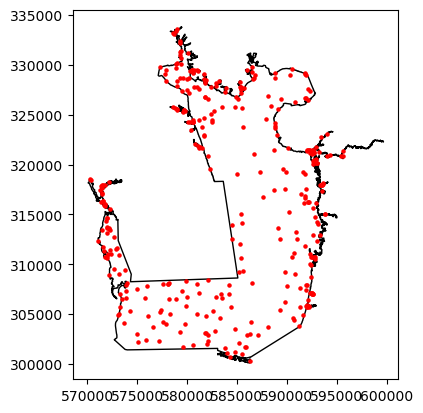

In [11]:
fig, ax = plt.subplots()
extentShp.plot(ax = ax, color='white', edgecolor='black')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)

In [12]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')
extent

'570046.86595991 300176.58137889 599619.25101178 333834.12379658'

# Ordinary Kriging

Run Oridinary Kriging for dry season data

In [13]:
search_radius = 20000
#with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
    out_surface_raster = arcpy.sa.Kriging(in_point_features = gis_path+"gdfDry.shp",
                                          z_field = "ResultValu",
                                          kriging_model = KrigingModelOrdinary("Spherical # # # #"),
                                         search_radius = RadiusVariable(20, search_radius))
                                                                               
#                                          "Spherical 0.000486 # # #",
#                                          0.000764192085967863,
#                                          "VARIABLE 12",
                                           
    out_surface_raster.save(gis_path+"dryKriging.tif")

Run Ordinary Kriging for wet season data

In [14]:
with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
    out_surface_raster = arcpy.sa.Kriging(gis_path+"gdfWet",
                                          "ResultValu",
                                         kriging_model = KrigingModelOrdinary("Spherical # # # #"),
                                         search_radius = RadiusVariable(20, search_radius))
#                                           "Spherical 0.000486 # # #",
#                                           0.000764192085967863,
#                                          "VARIABLE 12",
                                          
    out_surface_raster.save(gis_path+"wetKriging2.tif")

### Visualize interpolated rasters

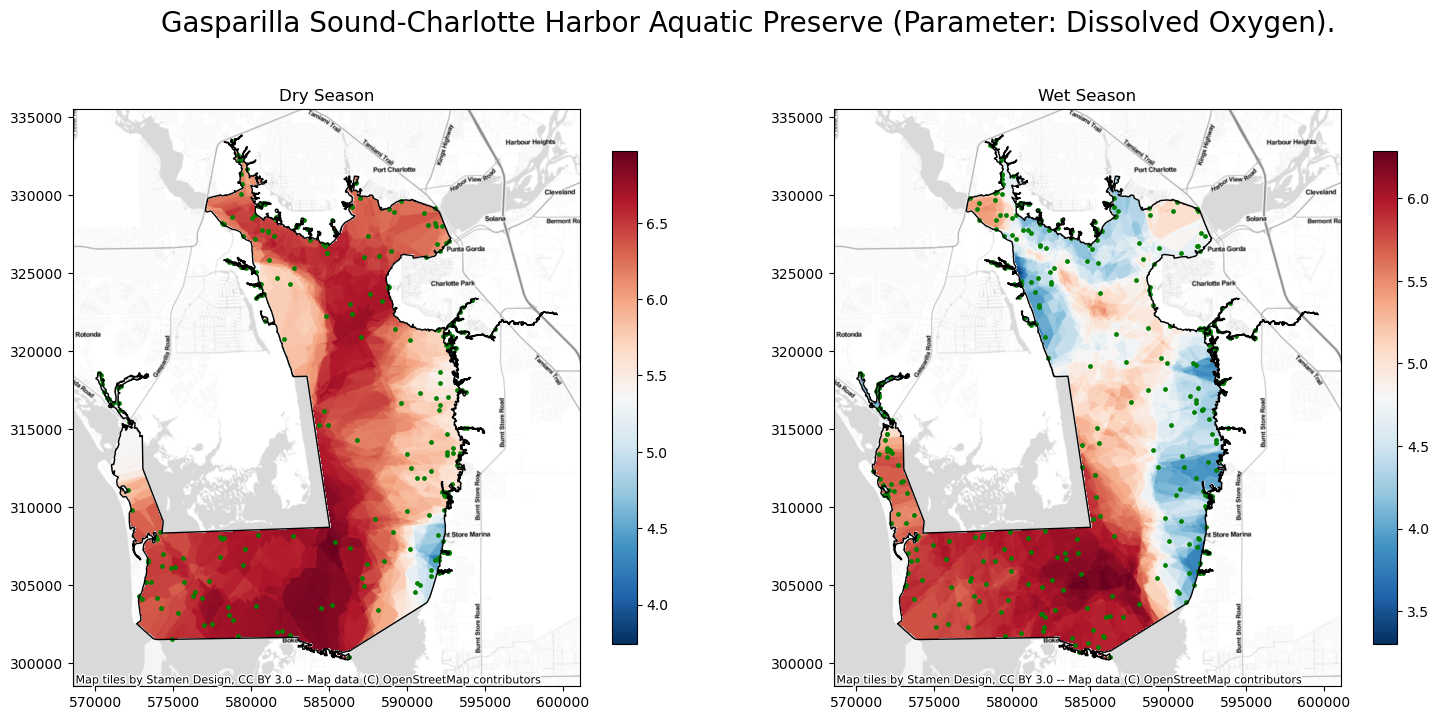

In [16]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[0], color='none', edgecolor='black')
cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "dryKriging.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
    axes[0].set_title('Dry Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[0],shrink=0.8)


gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[1], color='none', edgecolor='black')
cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "wetKriging2.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
    axes[1].set_title('Wet Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[1],shrink=0.8)


### An altnerative way to visualize raster

In [ ]:
# fig, ax5 , cbar1 = idw.show_map(
#     input_raster=gis_path + 'wetKriging.tif',
#     colormap="coolwarm",
#     image_size=1.5,
#     return_figure=True)
# ax6.set_title("Wet Season Interpolation in 2019 (OK) ")
# ax6.set_xlabel("Longitude")
# ax6.set_ylabel("Latitude")
# gdfDryShp.plot(ax = ax5, marker = 'o', color = 'green', markersize = 6)
# extentShp.plot(ax = ax5, color='none', edgecolor='black')

# cbar1.set_label(Para)

# fig, ax6 , cbar1 = idw.show_map(
#     input_raster=gis_path + 'wetKriging.tif',
#     colormap="coolwarm",
#     image_size=1.5,
#     return_figure=True)
# ax6.set_title("Wet Season Interpolation in 2019 (OK) ")
# ax6.set_xlabel("Longitude")
# ax6.set_ylabel("Latitude")
# gdfDryShp.plot(ax = ax6, marker = 'o', color = 'green', markersize = 6)
# extentShp.plot(ax = ax6, color='none', edgecolor='black')

# cbar1.set_label(Para)
# #cx.add_basemap(ax=ax6,source=cx.providers.Stamen.TonerLite,crs='EPSG:'+SpatialRef)


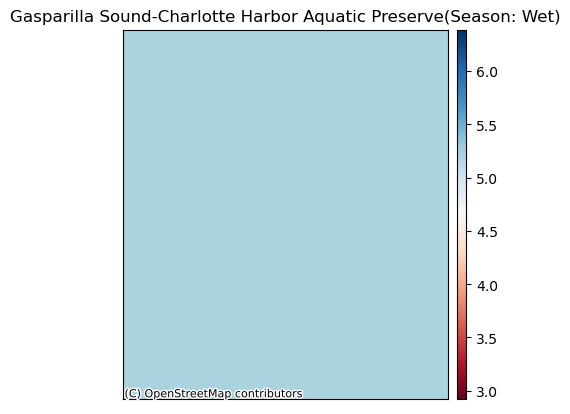

In [119]:
f, ax1 = plt.subplots()
with rio.open(gis_path+"wetKriging.tif") as wetOK:
    wetOK_array = wetOK.read(1)
    wetOK_array = np.where(wetOK_array < 0, np.nan, wetOK_array)
    ep.plot_bands(wetOK_array,
                  ax = ax1,
                  title=Area + '(Season: Wet)',
                  cmap="RdBu")
    cx.add_basemap(ax=ax1, source = cx.providers.OpenStreetMap.Mapnik,crs="EPSG:"+SpatialRef)

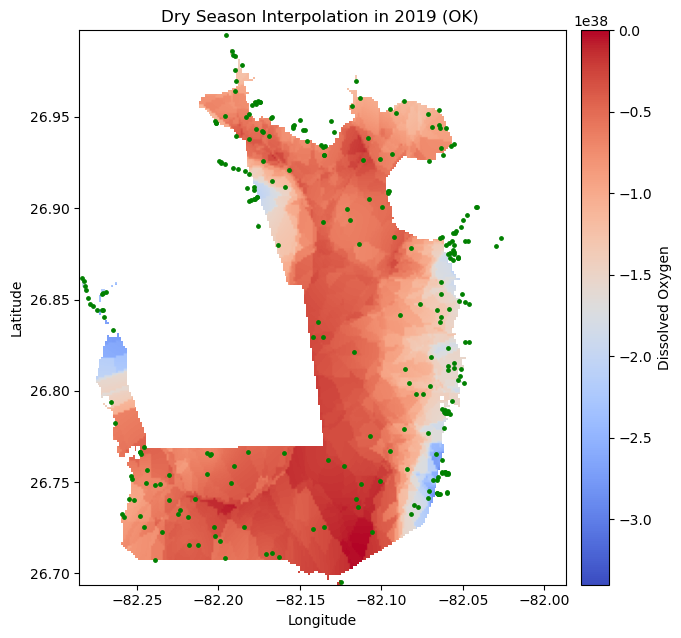

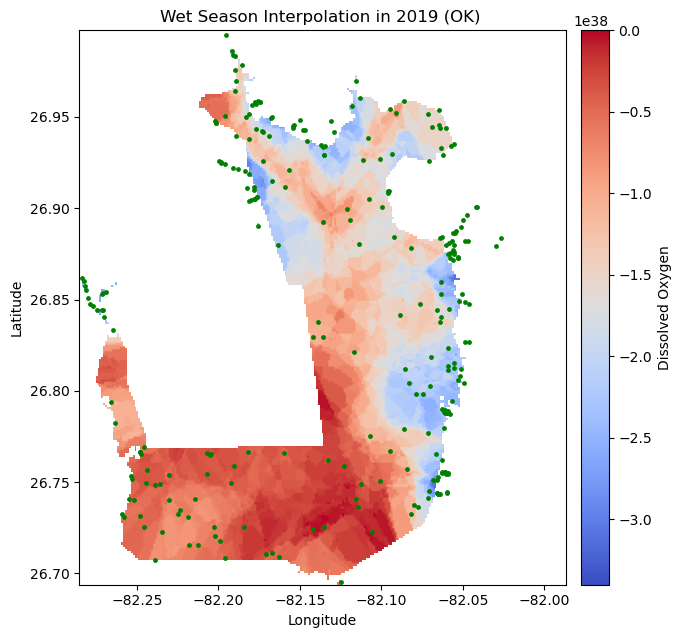

In [335]:
Para
fig, ax5 , cbar1 = idw.show_map(
    input_raster = gis_path + 'dryKriging.tif',
    colormap="coolwarm",
    image_size=1.5,
    return_figure=True)
ax5.set_title("Dry Season Interpolation in 2019 (OK) ")
ax5.set_xlabel("Longitude")
ax5.set_ylabel("Latitude")
gdfDryShp.plot(ax = ax5, marker = 'o', color = 'green', markersize = 6)
cbar1.set_label(Para)

fig, ax6 , cbar1 = idw.show_map(
    input_raster=gis_path + 'wetKriging.tif',
    colormap="coolwarm",
    image_size=1.5,
    return_figure=True)
ax6.set_title("Wet Season Interpolation in 2019 (OK) ")
ax6.set_xlabel("Longitude")
ax6.set_ylabel("Latitude")
gdfDryShp.plot(ax = ax6, marker = 'o', color = 'green', markersize = 6)
cbar1.set_label(Para)

# Inverse Distance Weighting (IDW)

Run IDW for both wet and dry seasons

In [17]:
with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), cellSize = 30):
    outIDW_dry = Idw(gis_path + "gdfDry.shp", "ResultValu")
    outIDW_wet = Idw(gis_path + "gdfWet.shp", "ResultValu")
    
    outIDW_dry.save(gis_path + 'dryIDW.tif')
    outIDW_wet.save(gis_path + 'wetIDW.tif')

Visualize the interpolated maps

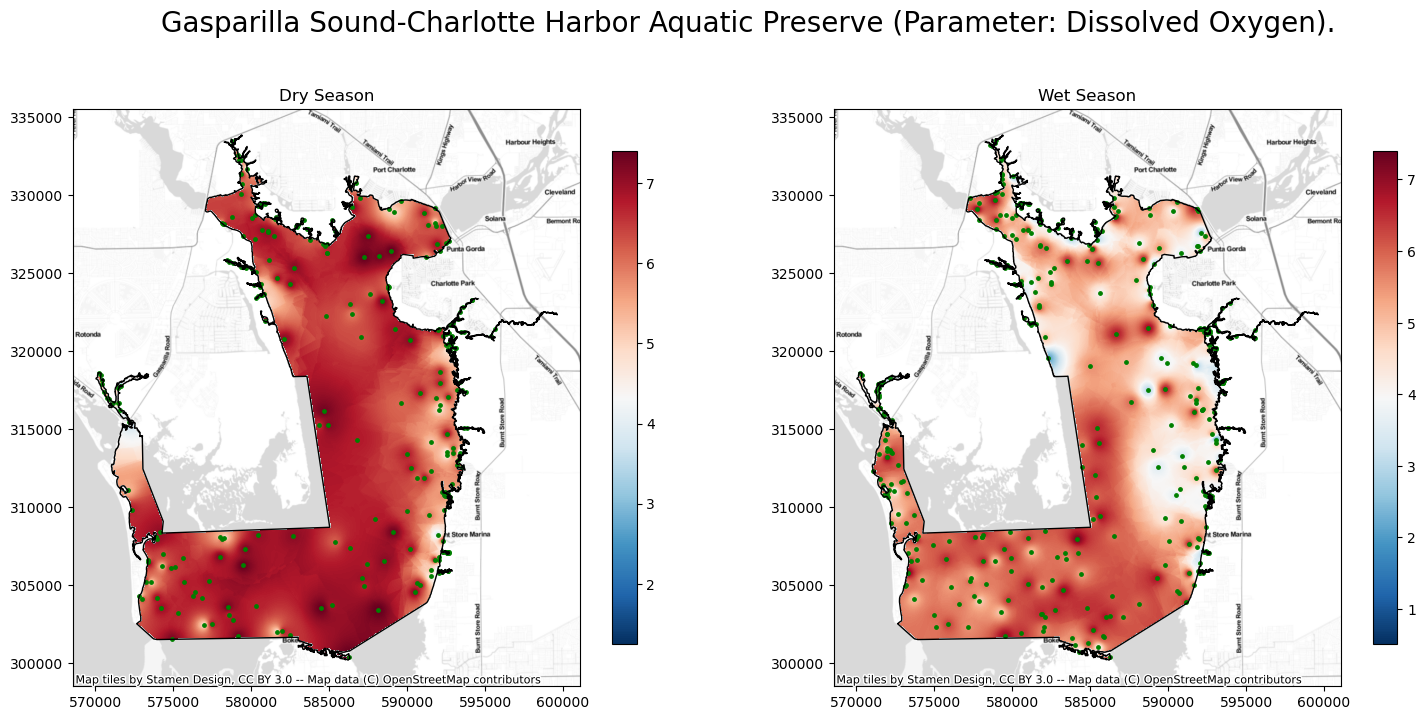

In [19]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[0], color='none', edgecolor='black')
cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "dryIDW.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
    axes[0].set_title('Dry Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[0],shrink=0.8)


gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[1], color='none', edgecolor='black')
cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "wetIDW.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
    axes[1].set_title('Wet Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[1],shrink=0.8)


# Empirical Bayesian Kriging (EBK)

Run EBK for wet and dry seasons

In [20]:
start_time = time.time()

with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), 
                      cellSize = 30, parallelProcessingFactor = "80%"):
    arcpy.ga.EmpiricalBayesianKriging(in_features = gis_path + 'gdfDry.shp', 
                                      z_field = "ResultValu", 
                                      out_raster = gis_path+"dryEBK.tif",
                                     # transformation_type = 'EMPIRICAL',
                                    search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))
    
    arcpy.ga.EmpiricalBayesianKriging(in_features = gis_path + 'gdfWet.shp', 
                                      z_field = "ResultValu", 
                                      out_raster = gis_path+"wetEBK.tif",
                                     # transformation_type = 'EMPIRICAL',
                                    search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5))
print("--- Time lapse: %s seconds ---" % (time.time() - start_time))

--- Time lapse: 532.771436214447 seconds ---


Visualize the interpolated maps

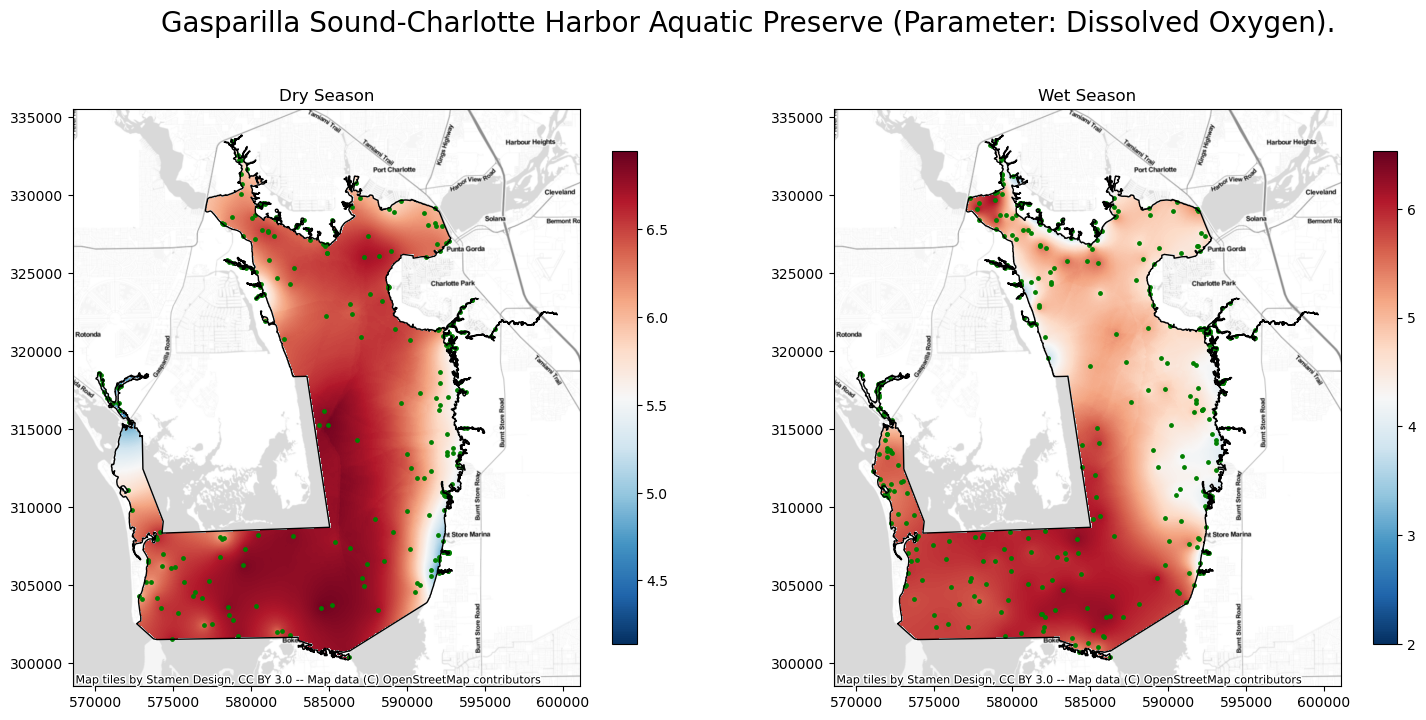

In [21]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

gdfDryShp.plot(ax = axes[0], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[0], color='none', edgecolor='black')
cx.add_basemap(ax = axes[0],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "dryEBK.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[0], cmap="RdBu_r")
    axes[0].set_title('Dry Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[0],shrink=0.8)


gdfWetShp.plot(ax = axes[1], marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = axes[1], color='none', edgecolor='black')
cx.add_basemap(ax = axes[1],source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

# Raster must added after basemap
with rasterio.open(gis_path + "wetEBK.tif", "r+") as dryOK:
    band = dryOK.read(1)
    band = numpy.ma.masked_array(band, mask=(band < 0))
    retted = rio_pl.show(band, transform=dryOK.transform, ax = axes[1], cmap="RdBu_r")
    axes[1].set_title('Wet Season')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=axes[1],shrink=0.8)


## Regression Kriging (RK)

Clip covariate rasters

EBK Regression Prediction in ArcGIS.

In [339]:
with arcpy.EnvManager(extent = extent, mask = path+"GIS_data/ch.shp",outputCoordinateSystem = arcpy.SpatialReference(3086), 
                      cellSize = 30, parallelProcessingFactor = "80%"):
    out_surface_raster = arcpy.EBKRegressionPrediction_ga(in_features = gis_path + "gdfDry.shp", 
                                                           z_field = "ResultValu", 
                                                            out_raster = gis_path + "DryRK"
                                                           transformation_type = 'EMPIRICAL',
                                                          max_local_points = 12,
                                                          search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5)) 
    
    out_surface_raster = arcpy.EBKRegressionPrediction_ga(in_features = gis_path + "gdfRK.shp", 
                                                           z_field = "ResultValu",
                                                          out_raster = gis_path + "wetRK"
                                                           transformation_type = 'EMPIRICAL',
                                                          max_local_points = 12,
                                                          search_neighborhood = arcpy.SearchNeighborhoodSmoothCircular(10000,0.5)) 

SyntaxError: invalid syntax (732943287.py, line 6)